# Full run through of raw images to classification with Convolutional Neural Network #

In this tutorial, we're going to be running through taking raw images that have been labeled for us already, and then feeding them through a convolutional neural network for classification. 

The images are either of dog(s) or cat(s). 

Once you have downloaded and extracted the data from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data, you're ready to begin.

# Part 1 - Preprocessing

We've got the data, but we can't exactly just stuff raw images right through our convolutional neural network. First, we need all of the images to be the same size, and then we also will probably want to just grayscale them. Also, the labels of "cat" and "dog" are not useful, we want them to be one-hot arrays. 

Interestingly, we may be approaching a time when our data might not need to be all the same size. Looking into TensorFlow's research blog: https://research.googleblog.com/2017/02/announcing-tensorflow-fold-deep.html

"TensorFlow Fold makes it easy to implement deep-learning models that operate over data of varying size and structure."

Fascinating...but, for now, we'll do it the old fashioned way.

<h4>Package Requirements</h4>
numpy (pip install numpy)
tqdm (pip install tqdm)

I will be using the GPU version of TensorFlow along with tflearn. 

To install the CPU version of TensorFlow, just do pip install tensorflow
To install the GPU version of TensorFlow, you need to get alllll the dependencies and such.

<strong>TensorFlow Installation tutorials:</strong>

<a href="https://pythonprogramming.net/how-to-cuda-gpu-tensorflow-deep-learning-tutorial/" target="blank">Installing the GPU version of TensorFlow in Ubuntu</a>

<a href="https://www.youtube.com/watch?v=r7-WPbx8VuY" target="blank">Installing the GPU version of TensorFlow on a Windows machine</a>

<strong>Using TensorFlow and concept tutorials:</strong>

<a href="https://pythonprogramming.net/neural-networks-machine-learning-tutorial" target="blank">Introduction to deep learning with neural networks</a>

<a href="https://pythonprogramming.net/tensorflow-introduction-machine-learning-tutorial/" target="blank">Introduction to TensorFlow</a>

<a href="https://pythonprogramming.net/convolutional-neural-network-cnn-machine-learning-tutorial/" target="blank">Intro to Convolutional Neural Networks</a>

<a href="https://pythonprogramming.net/cnn-tensorflow-convolutional-nerual-network-machine-learning-tutorial/" target="blank">Convolutional Neural Network in TensorFlow tutorial</a>

Finally, I will be making use of <a href="https://pythonprogramming.net/tflearn-machine-learning-tutorial/" target="blank">TFLearn</a>. Once you have TensorFlow installed, do pip install tflearn.


First, we'll get our imports and constants for preprocessing:

In [2]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion

TRAIN_DIR = r'C:\Users\maz\Desktop\image_classification\dogs vs cats\train'
TEST_DIR = r'C:\Users\maz\Desktop\image_classification\dogs vs cats\test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

Now, our first order of business is to convert the images and labels to array information that we can pass through our network. To do this, we'll need a helper function to convert the image name to an array. 

Our images are labeled like "cat.1" or "dog.3" and so on, so we can just split out the dog/cat, and then convert to an array like so:

In [3]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

Now, we can build another function to fully process the training images and their labels into arrays:

In [4]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

The tqdm module was introduced to me by one of my viewers, it's a really nice, pretty, way to measure where you are in a process, rather than printing things out at intervals...etc, it gives a progress bar. Super neat. 

Anyway, the above function converts the data for us into array data of the image and its label. 

When we've gone through all of the images, we shuffle them, then save. Shuffle modifies a variable in place, so there's no need to re-define it here. 

With this function, we will both save, and return the array data. This way, if we just change the neural network's structure, and not something with the images, like image size..etc..then we can just load the array file and save some processing time. While we're here, we might as well also make a function to process the testing data. This is the *actual* competition test data, NOT the data that we'll use to check the accuracy of our algorithm as we test. This data has no label. 

In [24]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

Now, we can run the training:

In [20]:
import os
os.getcwd()

'C:\\Users\\maz\\Desktop\\image_classification'

In [7]:
train_data = create_train_data()
# If you have already created the dataset:
#train_data = np.load('train_data.npy')

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:38<00:00, 653.00it/s]


In [26]:
test_data = process_test_data()
# If you have already created the dataset:
#test_data = np.load('test_data.npy')

100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [01:56<00:00, 97.44it/s]


# Convolutional Neural Network

Next, we're ready to define our neural network:

In [8]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

C:\Users\maz\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


What we have here is a nice, 2 layered convolutional neural network, with a fully connected layer, and then the output layer. It's been debated whether or not a fully connected layer is of any use. I'll leave it in anyway. 

This exact convnet was good enough for recognizing hand 28x28 written digits. Let's see how it does with cats and dogs at 50x50 resolution. 

Now, it wont always be the case that you're training the network fresh every time. Maybe first you just want to see how 3 epochs trains, but then, after 3, maybe you're done, or maybe you want to see about 5 epochs. We want to be saving our model after every session, and reloading it if we have a saved version, so I will add this:

In [9]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

Now, let's split out training and testing data:

In [10]:
train = train_data[:-500]
test = train_data[-500:]

Now, the training data and testing data are both labeled datasets. The training data is what we'll fit the neural network with, and the test data is what we're going to use to validate the results. The test data will be "out of sample," meaning the testing data will only be used to test the accuracy of the network, not to train it. 

We also have "test" images that we downloaded. THOSE images are not labeled at all, and those are what we'll submit to Kaggle for the competition.

Next, we're going to create our data arrays. For some reason, typical numpy logic like:

array[:,0] and array[:,1] did NOT work for me here. Not sure what I'm doing wrong, so I do this instead to separate my features and labels:

In [11]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

Now we fit for 3 epochs:

In [12]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 11.49667 | time: 97.381s
| Adam | epoch: 003 | loss: 11.49667 - acc: 0.5007 -- iter: 24448/24500
Training Step: 1149  | total loss: 11.46232 | time: 98.633s
| Adam | epoch: 003 | loss: 11.46232 - acc: 0.5022 | val_loss: 12.15765 - val_acc: 0.4720 -- iter: 24500/24500
--


Hmm... it doesn't look like we've gotten anywhere at all. 

We could keep trying, but, if you haven't made accuracy progress in the first 3 epochs, you're probably not going to at all, unless it's due to overfitment...at least in my experience. 

So... now what?

# Size Matters #
We're gonna need a bigger network

First, we need to reset the graph instance, since we're doing this in a continuous environment:

In [14]:
import tensorflow as tf
tf.reset_default_graph()

In [15]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.51273 | time: 105.218s
| Adam | epoch: 003 | loss: 0.51273 - acc: 0.7478 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.51436 | time: 106.512s
| Adam | epoch: 003 | loss: 0.51436 - acc: 0.7543 | val_loss: 0.55094 - val_acc: 0.7140 -- iter: 24500/24500
--


WELL WELL WELL... Looks like we've got a winner. With neural networks, size matters a ton. We went from having apparently un-trainable data to having obviously trainable data, and this was only 3 epochs. 

If you are happy with the model, go ahead and save it:

In [16]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\maz\Desktop\image_classification\dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


Now we can reload the model, and continue training (we don't NEED to reload the model here since this is continuous and the model is still in memory, but if you were running this as a program you would)

In [17]:
import tensorflow as tf
tf.reset_default_graph()

In [18]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('C:/Users/H/Desktop/KaggleDogsvsCats/{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 3829  | total loss: 0.22154 | time: 102.652s
| Adam | epoch: 010 | loss: 0.22154 - acc: 0.9082 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.20990 | time: 103.924s
| Adam | epoch: 010 | loss: 0.20990 - acc: 0.9127 | val_loss: 0.71744 - val_acc: 0.7800 -- iter: 24500/24500
--
INFO:tensorflow:C:\Users\maz\Desktop\image_classification\dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


# You can be too big #

Bigger is not always better, there does get to be a limit, at least from my experience. A bigger network figures things out better, and quicker, but tends to also overfit the training data. You can use dropout (sets randomly a certain % of nodes to not take part in the network for more robusts networks) to rectify this slightly, but there does seem to be a limit. 

Okay, now what? Let's see how we've done!

# Visually inspecting our network against unlabeled data #

In [23]:
os.listdir()
#test_data = np.load('test_data.npy')

['.ipynb_checkpoints',
 'checkpoint',
 'dataset',
 'dogs vs cats',
 'Dogs+vs+Cats+tutorial+code.ipynb',
 'Dogs+vs+Cats+tutorial+code.ipynb.txt',
 'dogsvscats-0.001-2conv-basic.model.data-00000-of-00001',
 'dogsvscats-0.001-2conv-basic.model.index',
 'dogsvscats-0.001-2conv-basic.model.meta',
 'log',
 'sample_submission.csv',
 'test',
 'test.zip',
 'train.zip',
 'train_data.npy']

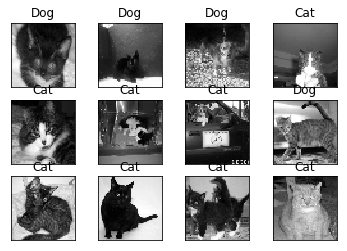

In [27]:
import matplotlib.pyplot as plt

# if you need to create the data:
#test_data = process_test_data()
# if you already have some saved:
test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

Alright, so we made a couple mistakes, but not too bad actually! 

If you're happy with it, let's compete!

In [48]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|███████████████████████████| 12500/12500 [00:22<00:00, 566.76it/s]


Heading to Kaggle > Competitions > Dogs vs. Cats Redux: Kernels Edition... Let's submit!

This got me ~700th place with a logloss of 0.55508